In [13]:
library(qiime2R)
library(tidyr)
library(tibble)
library(ggplot2)
library(vegan)
library(microbiome)
library(phyloseq)
library("tidyverse")
library("dplyr")
library("pairwiseAdonis"); packageVersion("pairwiseAdonis")


[1] ‘0.4.1’

In [2]:
# Read in the 16S qza files and clean them up for phyloseq
ASVs <- read_qza("/Users/stephanie.rosales/Documents/omics_projects/Resitada/qiime_output/table-BacArc_resistada.qza")
ASVs <- ASVs$data # Extract the count data from list

tree_file <-read_qza("/Users/stephanie.rosales/Documents/omics_projects/Resitada/qiime_output/rooted-BacArc_resistada.qza")$data


# Convert taxonomy info to data frame with correct taxonomy labels
taxa_16S <- read_qza("/Users/stephanie.rosales/Documents/omics_projects/Resitada/qiime_output/taxonomy_resistada.qza")
taxa_16S <- taxa_16S$data %>% as_tibble() %>% separate(Taxon, sep=";",
c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species")) %>% 

select(-Confidence) %>% arrange(Feature.ID) %>% mutate(ASV = 1:n()) %>% 
mutate(newcol = "ASV") %>%
unite("ASVs", newcol:ASV) %>%
filter(Phylum !=" p__Chlorophyta") %>%
filter(Phylum !="NA")

Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 5374 rows [3, 6, 9, 11,
12, 14, 15, 16, 17, 18, 22, 23, 27, 31, 36, 38, 42, 45, 49, 51, ...].”


In [3]:
#read metadata
meta = read.csv("/Users/stephanie.rosales/Documents/omics_projects/Resitada/metadata_RESISTADA.csv", 
                header = T, row.names = 1,
na.strings = c("", "NA"))

In [4]:
#create phyloseq objects
ps_pre= phyloseq(otu_table(ASVs, taxa_are_rows= T),
tax_table(as.data.frame(taxa_16S) %>% column_to_rownames("Feature.ID") %>%
as.matrix()), sample_data(meta), tree_file)
ps_pre

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 280 samples ]
sample_data() Sample Data:       [ 280 samples by 62 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

In [5]:
#remove samples sequenced twice
dups = c("N169_256_R2", "N157_265_R2", "N165_296_R2", "N161_A067_R2", "N185_A088_R2",
                                 "N164_A089_R2","N119_A107","N267_A110","N7_A114", "N156_A115","N158_A116",
                                 "N101_A118","N160_A119","N277_A125")

ps = subset_samples(ps_pre, !ID %in% dups & Genotype!=c("U41"))
                                                    #,"U44")) 
ps


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 257 samples ]
sample_data() Sample Data:       [ 257 samples by 62 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

In [6]:
#subset data
ps_Clipped =subset_samples(ps, Type=="Clipped")
ps_Clipped

ps_Clipped= subset_samples(ps_Clipped, filter_unpair=="no")
ps_Clipped


ps_paired = subset_samples(ps_Clipped, Pairs=="paired")
ps_paired

ps_Am_Pl =subset_samples(ps_Clipped, Combo=="Ambient_Placebo")
ps_Am_Pl


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 192 samples ]
sample_data() Sample Data:       [ 192 samples by 62 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 174 samples ]
sample_data() Sample Data:       [ 174 samples by 62 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 151 samples ]
sample_data() Sample Data:       [ 151 samples by 62 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 31 samples ]
sample_data() Sample Data:       [ 31 samples by 62 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

In [7]:
select =c( "Ambient_Pathogen", "NH4_Pathogen"
     
         )
#only disease
ps_disease =subset_samples(ps_paired , Combo %in% select)
ps_disease


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 75 samples ]
sample_data() Sample Data:       [ 75 samples by 62 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

In [8]:
#remove low abundant ASVs
ps_fill_clip = filter_taxa(ps_Clipped, function(x) sum(x > 5) > (0.01*length(x)), TRUE)
ps_fill_clip
                           
ps_paired_fill = filter_taxa(ps_paired, function(x) sum(x > 5) > (0.01*length(x)), TRUE)
ps_paired_fill                          
                                                       
                            
ps_Am_Pl_fill =filter_taxa(ps_Am_Pl, function(x) sum(x > 5) > (0.01*length(x)), TRUE)
ps_Am_Pl_fill       


ps_disease_fill =filter_taxa(ps_disease, function(x) sum(x > 5) > (0.01*length(x)), TRUE)
ps_disease_fill    

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1565 taxa and 174 samples ]
sample_data() Sample Data:       [ 174 samples by 62 sample variables ]
tax_table()   Taxonomy Table:    [ 1565 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1565 tips and 1323 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1437 taxa and 151 samples ]
sample_data() Sample Data:       [ 151 samples by 62 sample variables ]
tax_table()   Taxonomy Table:    [ 1437 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1437 tips and 1219 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1174 taxa and 31 samples ]
sample_data() Sample Data:       [ 31 samples by 62 sample variables ]
tax_table()   Taxonomy Table:    [ 1174 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1174 tips and 1131 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3769 taxa and 75 samples ]
sample_data() Sample Data:       [ 75 samples by 62 sample variables ]
tax_table()   Taxonomy Table:    [ 3769 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3769 tips and 3327 internal nodes ]

In [9]:
#transform data using center log ratio
ps_clr_clip <- microbiome::transform(ps_fill_clip, 'clr')
psr_clr.ord_clip <- ordinate(ps_clr_clip, "RDA", "euclidean")

ps_paired_fill_clr <- microbiome::transform(ps_paired_fill, 'clr')
ps_paired_fill_ord <- ordinate(ps_paired_fill_clr, "RDA", "euclidean")

                           
ps_Am_Pl_fill_clr <- microbiome::transform(ps_Am_Pl_fill, 'clr')
ps_Am_Pl_fill_ord <- ordinate(ps_Am_Pl_fill_clr, "RDA", "euclidean")


ps_disease_fill_clr <- microbiome::transform(ps_disease_fill, 'clr')
ps_disease_fill_ord <- ordinate(ps_disease_fill_clr , "RDA", "euclidean")

## Treatment

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = distances ~ group, data = df)

$group
                                        diff        lwr       upr     p adj
Ambient_Placebo-Ambient_Pathogen -14.7750338 -24.725082 -4.824986 0.0009429
NH4_Pathogen-Ambient_Pathogen     -2.6685444 -11.675056  6.337967 0.8684298
NH4_Placebo-Ambient_Pathogen     -13.9165941 -22.512963 -5.320225 0.0002492
NH4_Pathogen-Ambient_Placebo      12.1064894   3.190535 21.022444 0.0030509
NH4_Placebo-Ambient_Placebo        0.8584397  -7.643004  9.359884 0.9936796
NH4_Placebo-NH4_Pathogen         -11.2480497 -18.622895 -3.873204 0.0006383



Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
           Df Sum Sq Mean Sq      F N.Perm Pr(>F)    
Groups      3   6932 2310.72 10.306    999  0.001 ***
Residuals 170  38116  224.21                         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Pairwise comparisons:
(Observed p-value below diagonal, permuted p-value above diagonal)
                 Ambient_Pathogen Ambient_Placebo NH4_Pathogen NH4_Placebo
Ambient_Pathogen                       1.0000e-03   5.0600e-01       0.001
Ambient_Placebo        3.4423e-05                   6.0000e-03       0.754
NH4_Pathogen           4.8833e-01      2.1523e-03                    0.002
NH4_Placebo            9.5835e-06      7.7281e-01   3.2789e-04            

pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
NH4_Placebo vs NH4_Pathogen,1,3936.140,3.848338,0.03350800,0.001,0.006,*
NH4_Placebo vs Ambient_Placebo,1,1073.961,1.579417,0.01669938,0.041,0.246,
NH4_Placebo vs Ambient_Pathogen,1,5014.455,5.249444,0.05397917,0.001,0.006,*
NH4_Pathogen vs Ambient_Placebo,1,3439.546,3.017208,0.03724157,0.001,0.006,*
NH4_Pathogen vs Ambient_Pathogen,1,2175.000,1.474741,0.01879256,0.028,0.168,
Ambient_Placebo vs Ambient_Pathogen,1,4102.430,3.825728,0.06089428,0.001,0.006,*


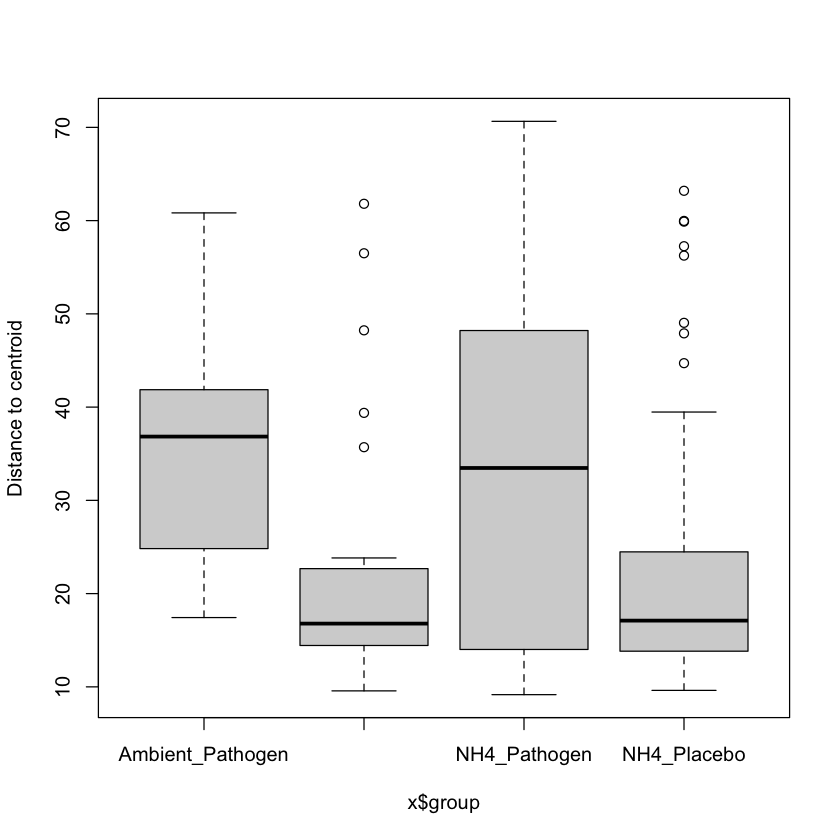

In [10]:
# Calculate distance matrix (Euclidean on CLR-transformed OTU table)
ps_clr <- vegdist(otu_table(t(ps_clr_clip)), method = "euclidean")

# Calculate multivariate dispersions
mod_T1 <- betadisper(ps_clr, sample_data(ps_clr_clip)$Combo)

# Test the pairwise comparisons for homogeneity of group dispersions (variances)
TukeyHSD(mod_T1)
permutest(mod_T1, pairwise = TRUE, permutations = 999)

# Boxplot of the dispersions
boxplot(mod_T1)

# Prepare metadata as a data frame (required for pairwise.adonis)
ps_clr_clip_df <- data.frame(sample_data(ps_clr_clip))

# Pairwise PERMANOVA test with Bonferroni correction
pairwise.adonis(ps_clr, factors = ps_clr_clip_df$Combo, 
                sim.method = "euclidean", p.adjust.m = "bonferroni")

# Genotype

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = distances ~ group, data = df)

$group
                          diff        lwr        upr     p adj
Cooper-9-Acerv2    13.26138689  -1.152881 27.6756544 0.1001906
Elkhorn-Acerv2     -1.70730993 -15.369692 11.9550718 0.9999954
FM14-Acerv2        -5.32091486 -18.598363  7.9565336 0.9556205
FM19-Acerv2        -4.00719604 -17.284644  9.2702524 0.9936190
FM6-Acerv2         -3.52405625 -16.984651  9.9365381 0.9978185
FM9-Acerv2         -6.18720052 -19.647795  7.2733938 0.9003147
K2-Acerv2          -3.59335678 -17.728280 10.5415665 0.9982641
Kelsey-1-Acerv2    -0.01822778 -13.680610 13.6441539 1.0000000
U44-Acerv2         22.75132423   9.290730 36.2119185 0.0000091
Elkhorn-Cooper-9  -14.96869682 -29.738299 -0.1990947 0.0441304
FM14-Cooper-9     -18.58230175 -32.996569 -4.1680342 0.0022370
FM19-Cooper-9     -17.26858292 -31.682850 -2.8543154 0.0065215
FM6-Cooper-9      -16.78544313 -31.368586 -2.202


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
           Df Sum Sq Mean Sq      F N.Perm Pr(>F)    
Groups      9  13631 1514.58 9.3057    999  0.001 ***
Residuals 164  26692  162.76                         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Pairwise comparisons:
(Observed p-value below diagonal, permuted p-value above diagonal)
             Acerv2   Cooper-9    Elkhorn       FM14       FM19        FM6
Acerv2              1.7000e-02 6.5000e-01 1.9400e-01 2.8300e-01 3.8700e-01
Cooper-9 1.8495e-02            1.3000e-02 3.0000e-03 2.0000e-03 8.0000e-03
Elkhorn  6.8011e-01 1.2205e-02            4.0300e-01 5.7200e-01 6.9400e-01
FM14     1.7428e-01 1.2826e-03 3.7425e-01            7.4200e-01 6.5400e-01
FM19     3.0625e-01 2.5867e-03 5.7261e-01 7.2978e-01            9.0500e-01
FM6      3.9632e-01 5.0964e-03 6.7501e-01 6.5741e-01 9.0547e-01           
FM9      7.7119e-02 3.7735e

pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Cooper-9 vs Kelsey-1,1,2321.7659,1.7147533,0.05582833,0.016,0.720,
Cooper-9 vs FM6,1,2273.5563,1.8664175,0.05857005,0.016,0.720,
Cooper-9 vs Acerv2,1,1926.1322,1.4832249,0.04566126,0.040,1.000,
Cooper-9 vs Elkhorn,1,2372.0206,1.8418916,0.05972045,0.004,0.180,
Cooper-9 vs FM19,1,2671.7953,2.2725608,0.06830135,0.004,0.180,
Cooper-9 vs FM9,1,2927.0351,2.6527175,0.08124033,0.002,0.090,
Cooper-9 vs U44,1,6758.3141,2.9254717,0.08885132,0.001,0.045,.
Cooper-9 vs K2,1,2204.0158,1.6739940,0.05838022,0.018,0.810,
Cooper-9 vs FM14,1,2535.9212,2.2260219,0.06699634,0.004,0.180,


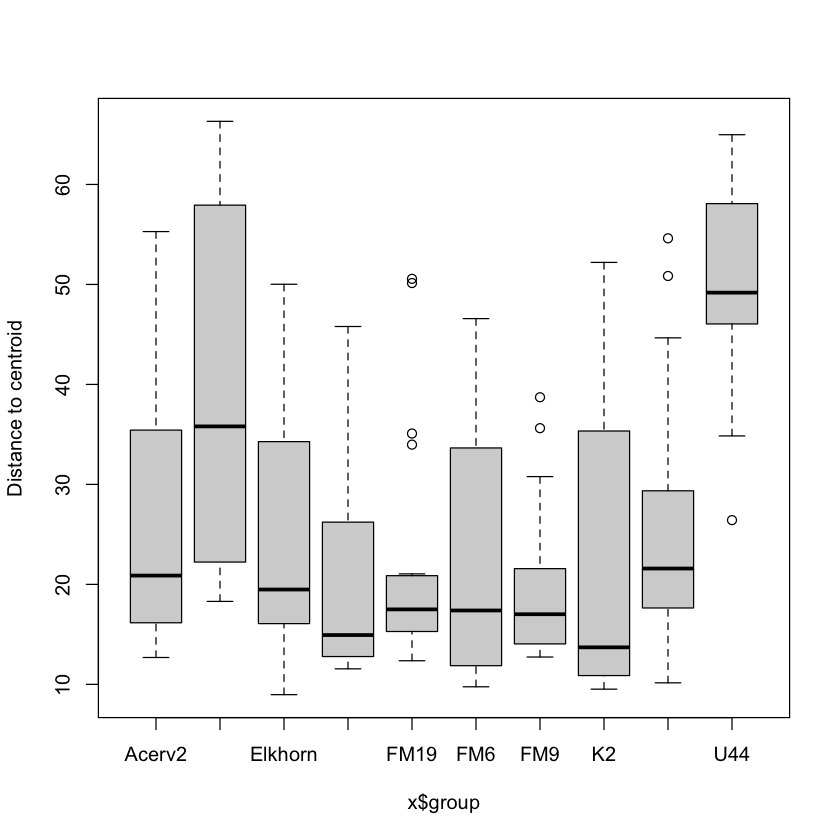

In [11]:
#Genotype differences under treatments

ps_clr <- vegdist(otu_table(t(ps_clr_clip)), method ="euclidean")
## Calculate multivariate dispersions
mod_T1 <- betadisper(ps_clr, sample_data(ps_clr_clip)$Genotype)
#test the pair-wise comparisons for Multivariate Homogeneity Of Groups Dispersions (Variances)
TukeyHSD(mod_T1)
permutest(mod_T1, pairwise = TRUE, permutations = 999)
boxplot(mod_T1)


pairwise.adonis(ps_clr, ps_clr_clip_df$Genotype, sim.method = "euclidean",
                p.adjust.m = "bonferroni")

# Outcome

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = distances ~ group, data = df)

$group
          diff      lwr     upr p adj
DL-AH 17.89262 13.91264 21.8726     0



Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
           Df Sum Sq Mean Sq      F N.Perm Pr(>F)    
Groups      1  13566 13565.7 78.744    999  0.001 ***
Residuals 172  29632   172.3                         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Pairwise comparisons:
(Observed p-value below diagonal, permuted p-value above diagonal)
          AH    DL
AH           0.001
DL 8.942e-16      

pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
DL vs AH,1,10223.67,9.96669,0.05477206,0.001,0.001,**


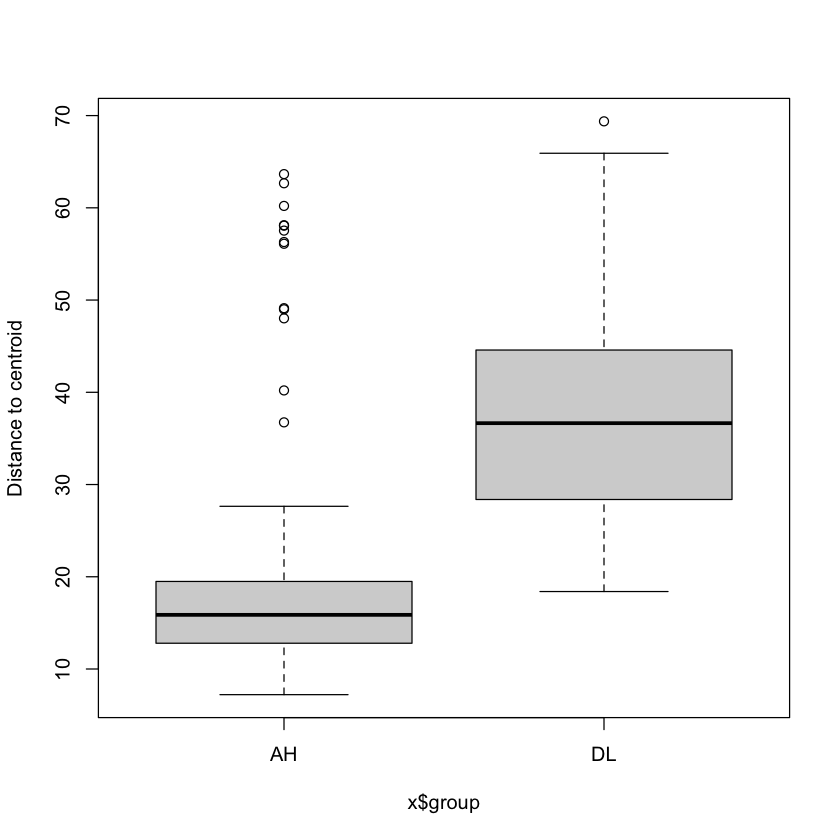

In [12]:
#health
ps_clr <- vegdist(otu_table(t(ps_clr_clip)), method ="euclidean")
## Calculate multivariate dispersions
mod_T1 <- betadisper(ps_clr, sample_data(ps_clr_clip)$Health)
#test the pair-wise comparisons for Multivariate Homogeneity Of Groups Dispersions (Variances)
TukeyHSD(mod_T1)
permutest(mod_T1, pairwise = TRUE, permutations = 999)
boxplot(mod_T1)


pairwise.adonis(ps_clr, ps_clr_clip_df$Health, sim.method = "euclidean",
                p.adjust.m = "bonferroni")